# PPO

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import PPOGym

from extravaganza.lifters import NoLift, RandomLift, LearnedLift
from extravaganza.sysid import SysID
from extravaganza.controllers import LiftedBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from experiments import run_experiment, ylim

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
LIFTER_AND_SYSID_SEED = None

## System
Here, we tune the parameters of a PPO algorithm learning on an OpenAI Gym environment. The PPO update step is
$$L^{CLIP}(\theta) = \mathbb{E} \left[ \min\left(r(\theta, \theta_{\text{old}}, s_t, a_t) \cdot \hat{A}_t, \text{clip}\left(r(\theta, \theta_{\text{old}}, s_t, a_t), 1 - \epsilon, 1 + \epsilon\right) \cdot \hat{A}_t\right)\right],
$$
and so we can tune the clip parameter $\epsilon$ in addition to learning rate $\eta$ and more.

We play on games like `CartPole`.

## Hyperparameters

In [2]:
# --------------------------------------------------------------------------------------
# ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

num_trials = 3
T = 3000
T0 = 500000
reset_condition = lambda t: False
wordy = True


# num_trials = 5
# T = 12000  # total timesteps
# T0 = 8000  # number of timesteps to just sysid for our methods
# reset_condition = lambda t: t <= 10000 and t % 1000 == 0  # when to reset the system
# wordy = True  # whether to print some things

# --------------------------------------------------------------------------------------
# --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
# --------------------------------------------------------------------------------------

du = 1  # control dim
initial_eps_clip = 0.1  # initial value for eps
def apply_control(control, system): system.ppo.eps_clip = initial_eps_clip * 1.5 ** np.clip(control.item(), -7, 7)

env_name = 'CartPole-v1'  
# env_name = 'MountainCarContinuous-v0'
continuous_action_space = False

system_args = {
    'apply_control': apply_control,
    'control_dim': du,
    'env_name': env_name,
    'lr_actor': 0.0003,
    'lr_critic': 0.001,
    'eps_clip': initial_eps_clip,
    'continuous_action_space': continuous_action_space,
    'gamma': 0.98,
    'max_episode_len': 400,
    'repeat': 10,
    'render': False,
    'seed': SYSTEM_SEED,
}
make_system = lambda : PPOGym(**system_args)

# --------------------------------------------------------------------------------------
# ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

sysid_method = 'regression'
sysid_scale = 0.05

learned_lift_args = {
    'lift_lr': 0.004,
    'sysid_lr': 0.004,
    'cost_lr': 0.001,
    'depth': 4,
    'buffer_maxlen': int(1e6),
    'num_epochs': 100,
    'batch_size': 64,
    'seed': LIFTER_AND_SYSID_SEED
}

# --------------------------------------------------------------------------------------
# ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

h = 10  # controller memory length (# of w's to use on inference)
hh = 10  # history length of the cost/control histories
lift_dim = 20  # dimension to lift to

m_update_rescaler = lambda : ADAM(0.002, betas=(0.9, 0.999))
m0_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
k_update_rescaler = lambda : ADAM(0.002, betas=(0.9, 0.999))

lifted_bpc_args = {
    'h': h,
    'method': 'REINFORCE',
    'initial_scales': (0.01, 0.01, 0.01),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
    'T0': T0,
#     'bounds': (-5, 5),
    'initial_u': jnp.zeros(du),
    'decay_scales': False,
    'use_tanh': False,
    'use_K_from_sysid': False,
    'seed': CONTROLLER_SEED
}

make_controllers = {
    # these are w.r.t initial value of 0.1 with base of 1.5
    '0.01': lambda sys: ConstantController(-5.67887358, du),
    '0.1': lambda sys: ConstantController(0, du),
    '0.2': lambda sys: ConstantController(1.71, du),
    '0.9': lambda sys: ConstantController(5.419, du),

#     'No Lift': lambda sys: LiftedBPC(lifter=NoLift(hh, du, LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, hh, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
#     'Random Lift': lambda sys: LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, lift_dim, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
#     'Learned Lift': lambda sys: LiftedBPC(lifter=LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args), **lifted_bpc_args)
}

## Plotting
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [3]:
def plot_ppo(all_stats):
    # clear plot and calc nrows
    plt.clf()
    n = 5
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 4 * nrows))

    # plot system and controller stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'eps_clip', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'us', label=method)
        stats.plot(ax[2, 0], 'rewards', label=method)
        stats.plot(ax[2, 1], 'avg costs since reset', label=method)
    
        stats.plot(ax[3, 0], '||A||_op', label=method)
        stats.plot(ax[3, 1], '||B||_F', label=method)
        stats.plot(ax[4, 0], '||A-BK||_op', label=method)
        stats.plot(ax[4, 1], 'lifter losses', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('state'); _ax.legend(); ylim(_ax, -1, 2)
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend(); ylim(_ax, -5, 5)
    _ax = ax[1, 0]; _ax.set_title('controls'); _ax.legend(); ylim(_ax, -3, 3)
    
    _ax = ax[2, 0]; _ax.set_title('instantaneous rewards'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('avg rewards since reset'); _ax.legend()    
    
    _ax = ax[3, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[4, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[4, 1]; _ax.set_title('lifter losses'); _ax.legend()
    pass

## actually run the thing :)

--------------------------------------------------
----------------- TRIAL 0 -----------------------
--------------------------------------------------

testing 0.01
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:27<00:00, 108.82it/s, control=-5.68, cost=-20]



testing 0.1
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:30<00:00, 98.85it/s, control=0, cost=-310]



testing 0.2
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:31<00:00, 95.82it/s, control=1.71, cost=-400]



testing 0.9
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:31<00:00, 96.13it/s, control=5.42, cost=-139]



--------------------------------------------------
----------------- TRIAL 1 -----------------------
--------------------------------------------------

testing 0.01
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:27<00:00, 109.39it/s, control=-5.68, cost=-10]



testing 0.1
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:30<00:00, 98.40it/s, control=0, cost=-100]



testing 0.2
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:31<00:00, 96.71it/s, control=1.71, cost=-90]



testing 0.9
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:31<00:00, 94.83it/s, control=5.42, cost=-90]



--------------------------------------------------
----------------- TRIAL 2 -----------------------
--------------------------------------------------

testing 0.01
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:28<00:00, 106.23it/s, control=-5.68, cost=-25]



testing 0.1
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|█████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:30<00:00, 97.89it/s, control=0, cost=-90]



testing 0.2
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:30<00:00, 97.43it/s, control=1.71, cost=-131]



testing 0.9
WARNING (<class 'extravaganza.dynamical_systems.PPOGym'>): no `Stats` object provided, so a new one will be made.
registering running average of rewards
WARNING (<class 'extravaganza.controllers.ConstantController'>): no `Stats` object provided, so a new one will be made.


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:31<00:00, 95.19it/s, control=5.42, cost=-90]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

<Figure size 640x480 with 0 Axes>

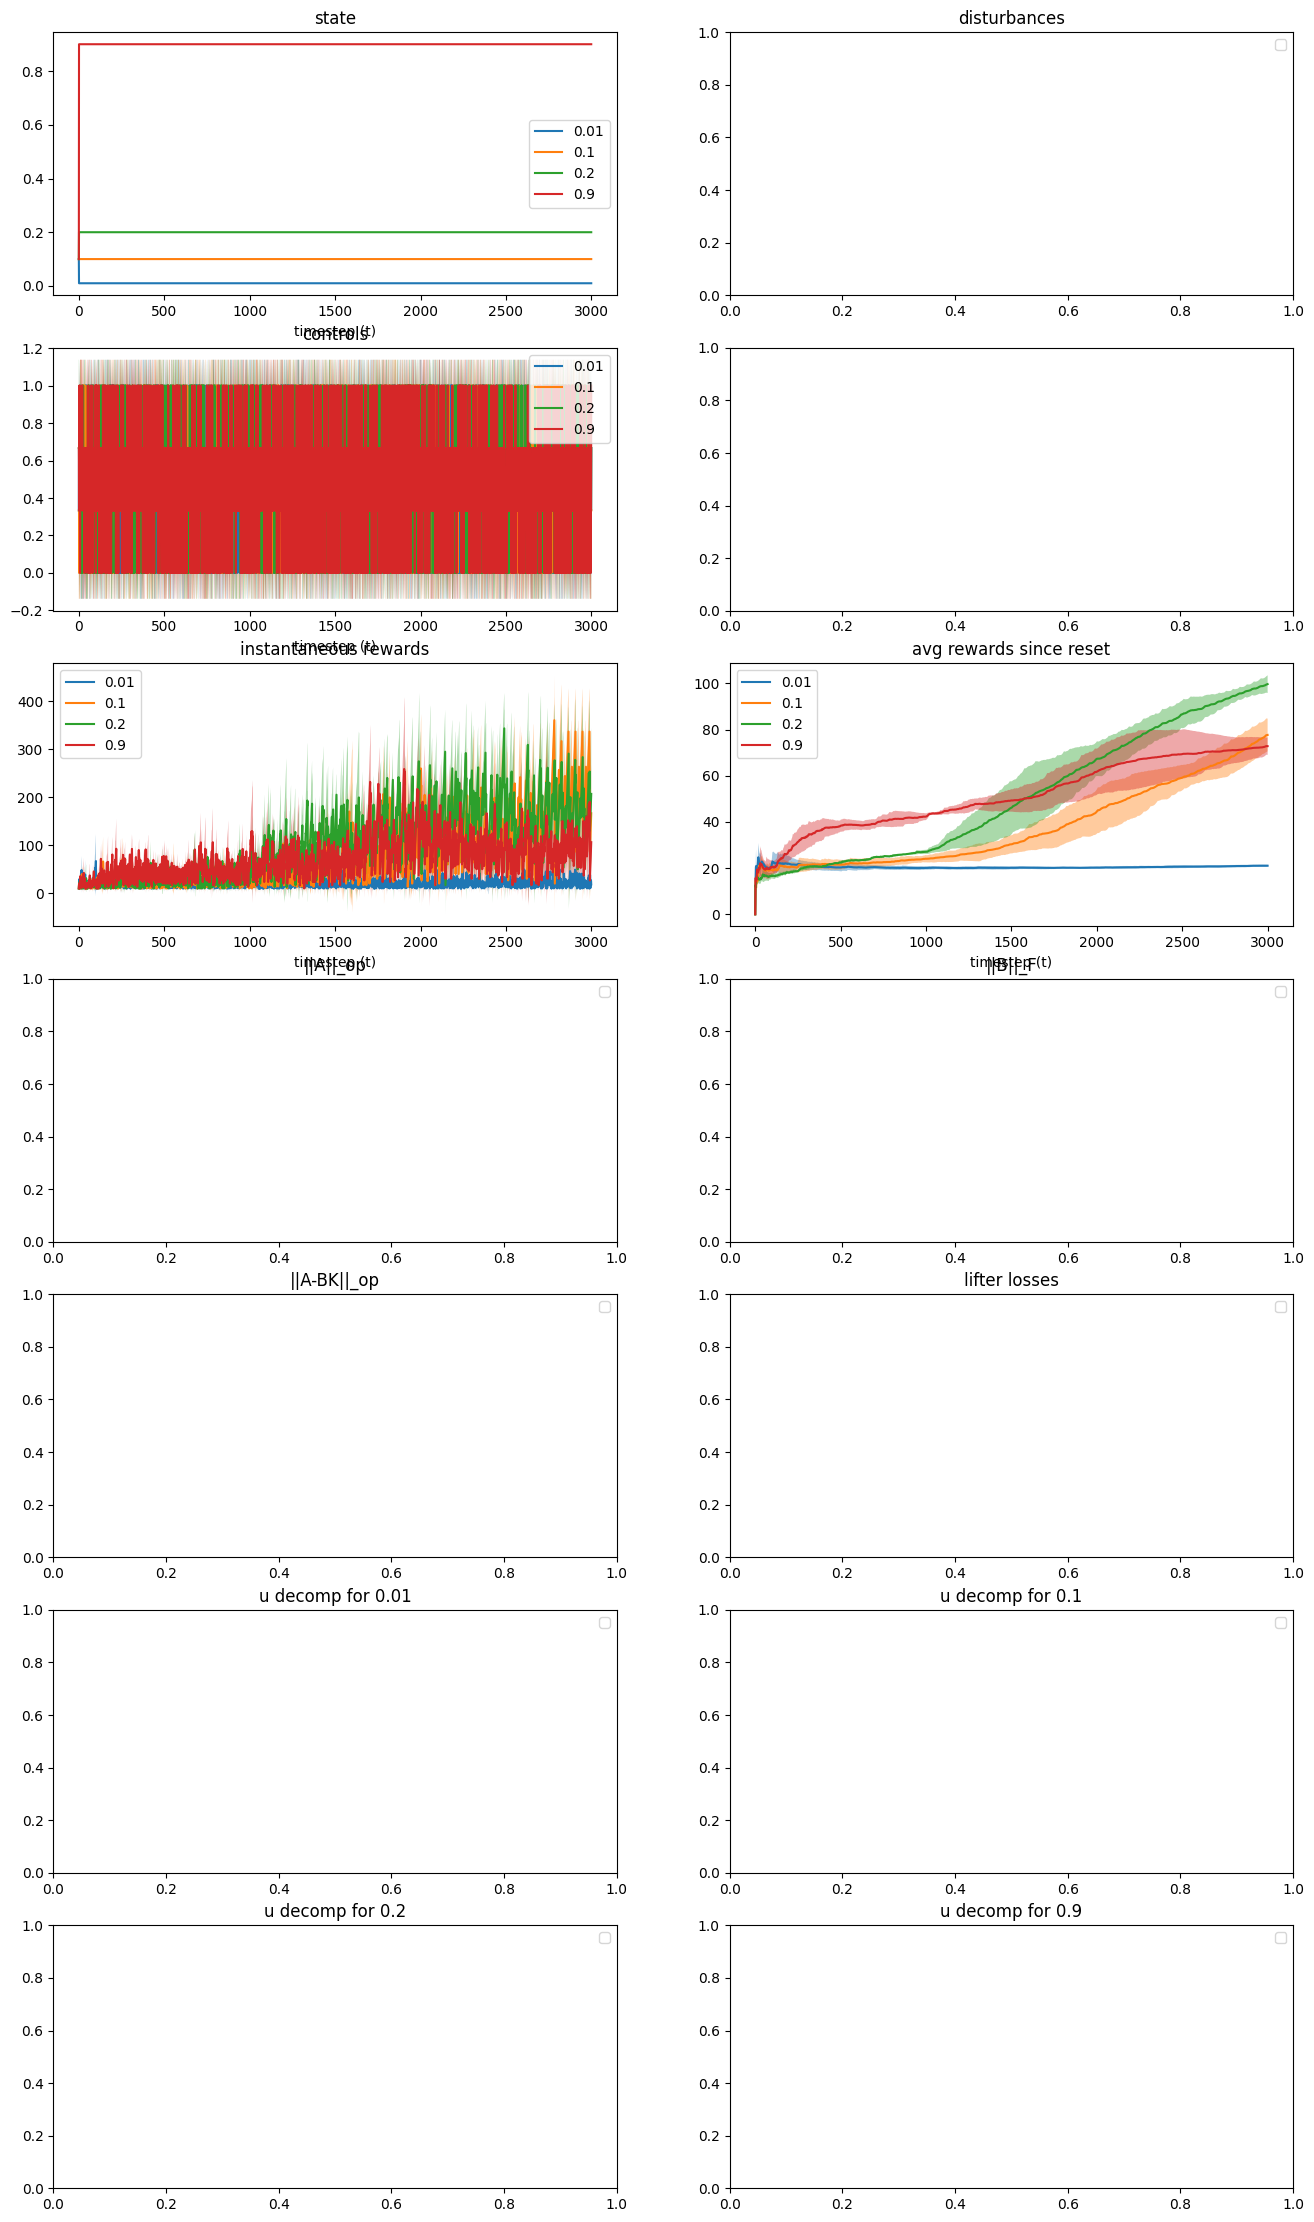

In [4]:
experiment_args = {
    'make_system': make_system,
    'make_controllers': make_controllers,
    'num_trials': num_trials,
    'T': T,
    'reset_condition': reset_condition,
    'reset_seed': SYSTEM_SEED,
    'wordy': wordy,
    
}
stats = run_experiment(**experiment_args)
plot_ppo(stats)